<a href="https://colab.research.google.com/github/nitrogenlab/GP15_watermassanalysis/blob/main/ThermoclineSplittingDev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install gsw
import gsw

In [11]:
!wget https://cchdo.ucsd.edu/data/16482/33RR20180918_ct1.zip -O 33RR20180918_ct1.zip

--2021-06-21 09:03:05--  https://cchdo.ucsd.edu/data/16482/33RR20180918_ct1.zip
Resolving cchdo.ucsd.edu (cchdo.ucsd.edu)... 44.241.13.136
Connecting to cchdo.ucsd.edu (cchdo.ucsd.edu)|44.241.13.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3224609 (3.1M) [application/zip]
Saving to: ‘33RR20180918_ct1.zip’

33RR20180918_ct1.zi 100%[===================>]   3.08M  7.65MB/s    in 0.4s    

2021-06-21 09:03:06 (7.65 MB/s) - ‘33RR20180918_ct1.zip’ saved [3224609/3224609]



In [12]:
!unzip 33RR20180918_ct1.zip

Archive:  33RR20180918_ct1.zip
  inflating: 33RR20180918_00001_00002_ct1.csv  
  inflating: 33RR20180918_00001_00003_ct1.csv  
  inflating: 33RR20180918_00002_00003_ct1.csv  
  inflating: 33RR20180918_00003_00002_ct1.csv  
  inflating: 33RR20180918_00003_00003_ct1.csv  
  inflating: 33RR20180918_00003_00004_ct1.csv  
  inflating: 33RR20180918_00003_00006_ct1.csv  
  inflating: 33RR20180918_00004_00002_ct1.csv  
  inflating: 33RR20180918_00004_00003_ct1.csv  
  inflating: 33RR20180918_00004_00005_ct1.csv  
  inflating: 33RR20180918_00004_00006_ct1.csv  
  inflating: 33RR20180918_00004_00008_ct1.csv  
  inflating: 33RR20180918_00004_00009_ct1.csv  
  inflating: 33RR20180918_00004_00011_ct1.csv  
  inflating: 33RR20180918_00005_00002_ct1.csv  
  inflating: 33RR20180918_00005_00003_ct1.csv  
  inflating: 33RR20180918_00005_00005_ct1.csv  
  inflating: 33RR20180918_00005_00006_ct1.csv  
  inflating: 33RR20180918_00005_00009_ct1.csv  
  inflating: 33RR20180918_00006_00002_ct1.csv  
  inflati

In [15]:
import pandas as pd
from io import StringIO
from collections import namedtuple
import glob


def parse_ctd_dataset(filename):
  num_headers = None
  headers_passed = 0
  table_line_number = 0
  latitude = None
  longitude = None
  core_file_contents = ""
  with open(filename) as fh:
    for line in fh:
      line = line.rstrip("\n")
      if line.startswith("NUMBER_HEADERS"):
        num_headers = int(line.split(" = ")[1])
        headers_passed += 1
      elif num_headers is None:
        continue #haven't seen the num_headers line yeat
      else:
        if (headers_passed < num_headers):
          headers_passed += 1
          if (line.startswith("LATITUDE")):
            latitude = float(line.split(" = ")[1])
          if (line.startswith("LONGITUDE")):
            longitude = float(line.split(" = ")[1])
        else:
          #actually parsing the table
          table_line_number += 1
          if (table_line_number==1):
            core_file_contents += line+",LATITUDE,LONGITUDE\n" #header
          elif table_line_number==2:
            continue #this is a line with the units
          else:
            if (line.startswith("END_DATA")==False):
              core_file_contents +=\
                line+","+str(latitude)+","+str(longitude)+"\n"
            else:
              return pd.read_csv(StringIO(core_file_contents)), latitude, longitude


def get_density_depth_info(df, salinity_col="CTDSAL",
                                  temp_col="CTDTMP",
                                  pressure_col="CTDPRS",
                                  latitude_col="LATITUDE",
                                  longitude_col="LONGITUDE"):
  absolute_salinity = gsw.SA_from_SP(SP=df[salinity_col],
                                     p=df[pressure_col],
                                     lon=df[longitude_col],
                                     lat=df[latitude_col])
  conservative_temp = gsw.CT_from_t(SA=absolute_salinity,
                                    t=df["CTDTMP"], p=df["CTDPRS"])
  sig0 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=0) - 1000

  z = gsw.z_from_p(p=df[pressure_col], lat=df[latitude_col])
  depth = -z #https://github.com/TEOS-10/python-gsw/blob/7d6ebe8114c5d8b4a64268d36100a70e226afaf6/gsw/gibbs/conversions.py#L577
  return sig0, depth


StnData = namedtuple("StnData", ["df", "pressure", "sig0", "depth",
                                 "lat", "lon", "cast"])


def parse_all_station_cast_info(files):
  stn_to_data = {}
  for file in files:
    print("Parisng:",file)
    _, stnstr, stncast, _ = file.split("_")
    stn = int(stnstr)
    cast = int(stncast)
    print("On station",stn,"cast",cast)
    ctd_df, lat, lon = parse_ctd_dataset(file)
    sig0, depth = get_density_depth_info(df=ctd_df)
    stn_data = StnData(df=ctd_df, pressure=ctd_df["CTDPRS"],
                       sig0=sig0, depth=depth, lat=lat, lon=lon, cast=cast)
    if (stn not in stn_to_data):
      stn_to_data[stn] = stn_data
    else:
      #take the deepest cast for a given station
      if (len(sig0) > len(stn_to_data[stn].sig0)): 
        print("Replacing cast",stn_to_data[stn].cast,
              "and length",len(stn_to_data[stn].sig0),
              "with cast",cast,"and length",len(sig0))
  return stn_to_data

stn_to_data = parse_all_station_cast_info(glob.glob("33RR20180918*.csv"))
#parse_ctd_dataset("33RR20180918_00001_00002_ct1.csv")

Parisng: 33RR20180918_00021_00011_ct1.csv
On station 21 cast 11
Parisng: 33RR20180918_00039_00006_ct1.csv
On station 39 cast 6
Parisng: 33RR20180918_00035_00010_ct1.csv
On station 35 cast 10
Parisng: 33RR20180918_00025_00011_ct1.csv
On station 25 cast 11
Parisng: 33RR20180918_00008_00010_ct1.csv
On station 8 cast 10
Parisng: 33RR20180918_00004_00006_ct1.csv
On station 4 cast 6
Parisng: 33RR20180918_00015_00002_ct1.csv
On station 15 cast 2
Parisng: 33RR20180918_00016_00003_ct1.csv
On station 16 cast 3
Parisng: 33RR20180918_00001_00003_ct1.csv
On station 1 cast 3
Parisng: 33RR20180918_00019_00004_ct1.csv
On station 19 cast 4
Parisng: 33RR20180918_00021_00008_ct1.csv
On station 21 cast 8
Parisng: 33RR20180918_00035_00009_ct1.csv
On station 35 cast 9
Parisng: 33RR20180918_00023_00005_ct1.csv
On station 23 cast 5
Parisng: 33RR20180918_00038_00003_ct1.csv
On station 38 cast 3
Parisng: 33RR20180918_00006_00002_ct1.csv
On station 6 cast 2
Parisng: 33RR20180918_00008_00009_ct1.csv
On station 8 

Parisng: 33RR20180918_00005_00005_ct1.csv
On station 5 cast 5
Parisng: 33RR20180918_00023_00013_ct1.csv
On station 23 cast 13
Replacing cast 5 and length 2642 with cast 13 and length 2657
Parisng: 33RR20180918_00020_00002_ct1.csv
On station 20 cast 2
Replacing cast 3 and length 505 with cast 2 and length 529
Parisng: 33RR20180918_00037_00002_ct1.csv
On station 37 cast 2
Parisng: 33RR20180918_00039_00009_ct1.csv
On station 39 cast 9
Parisng: 33RR20180918_00034_00003_ct1.csv
On station 34 cast 3
Parisng: 33RR20180918_00019_00002_ct1.csv
On station 19 cast 2
Replacing cast 4 and length 543 with cast 2 and length 1014
Parisng: 33RR20180918_00019_00012_ct1.csv
On station 19 cast 12
Replacing cast 4 and length 543 with cast 12 and length 984
Parisng: 33RR20180918_00016_00005_ct1.csv
On station 16 cast 5
Parisng: 33RR20180918_00025_00005_ct1.csv
On station 25 cast 5
Parisng: 33RR20180918_00033_00009_ct1.csv
On station 33 cast 9
Replacing cast 5 and length 454 with cast 9 and length 937
Parisn

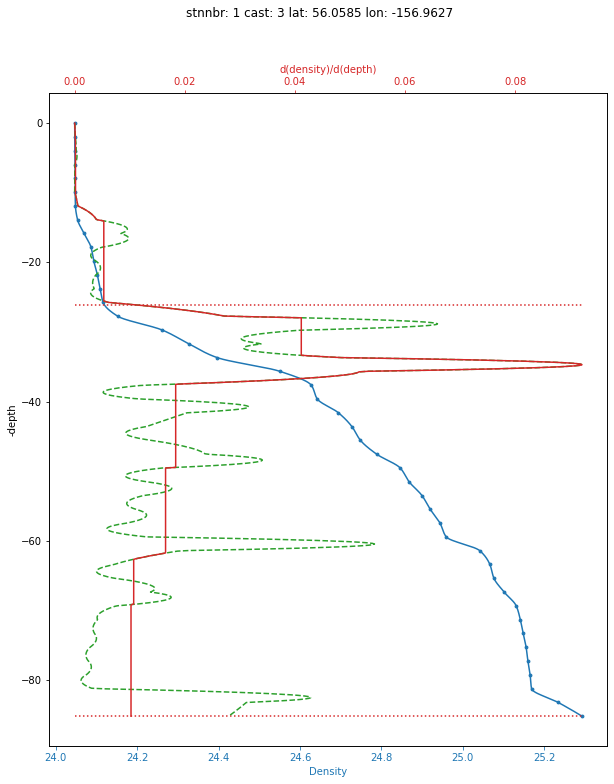

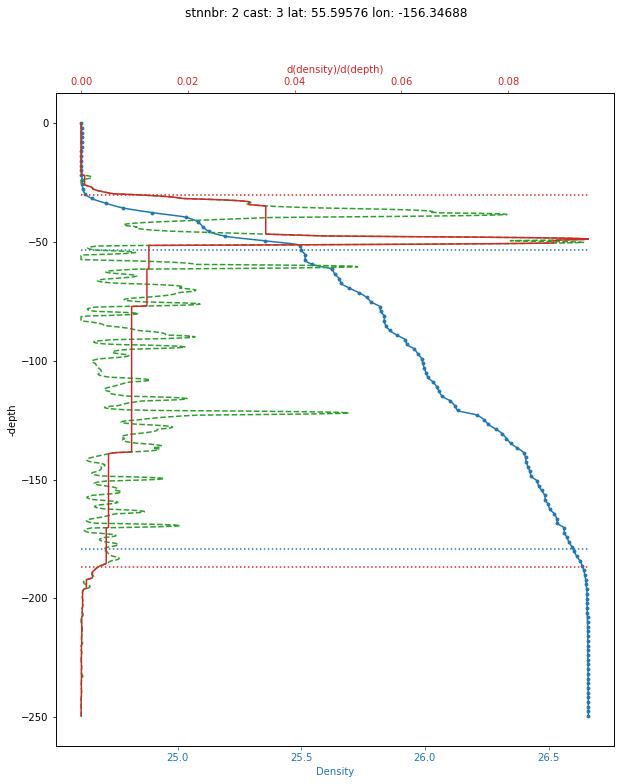

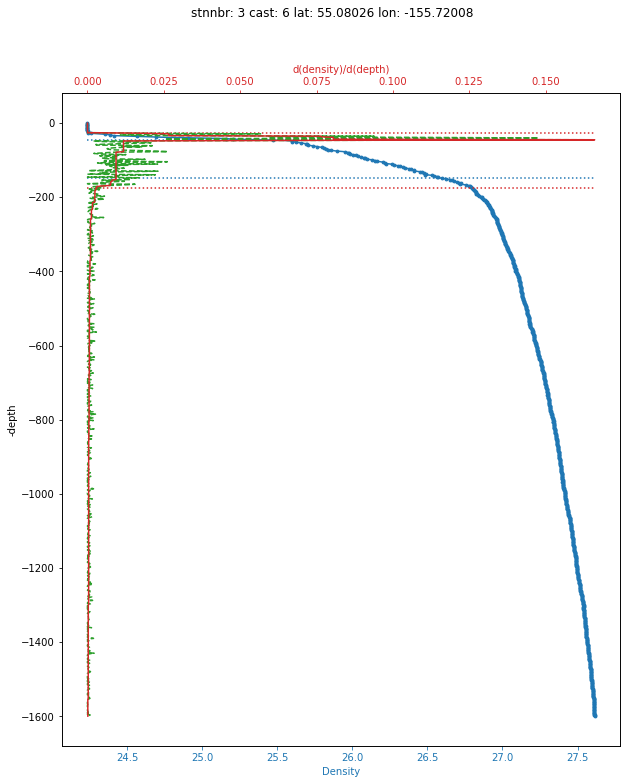

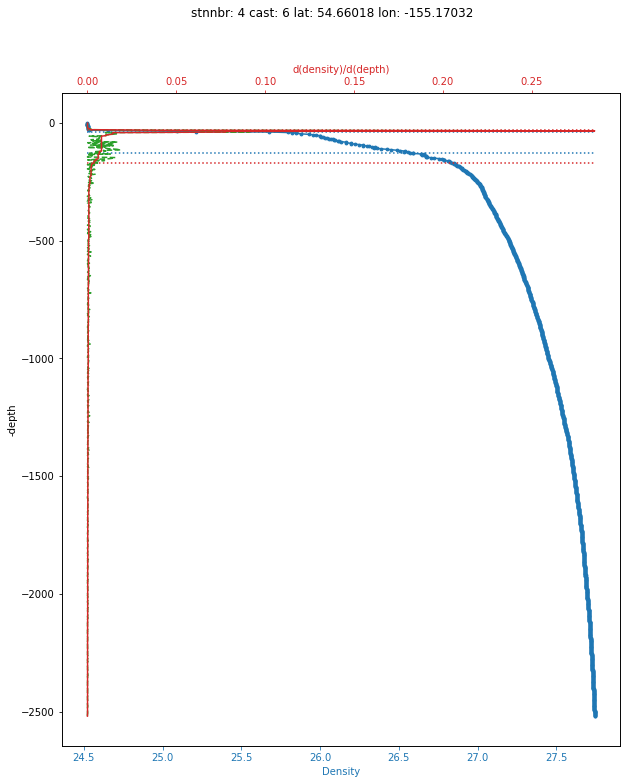

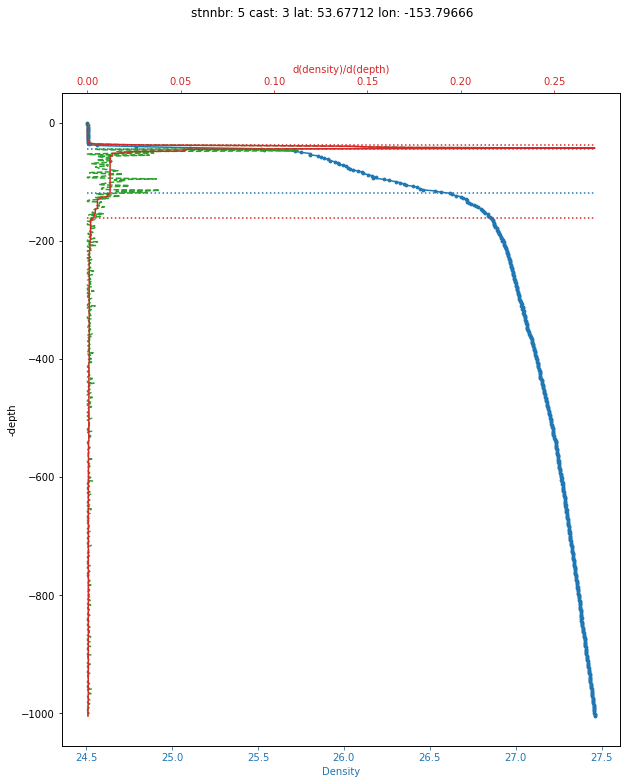

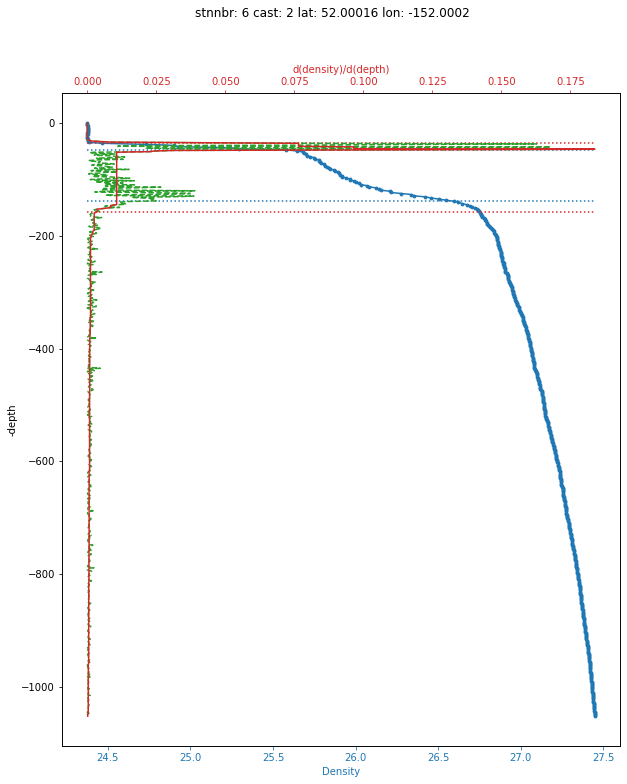

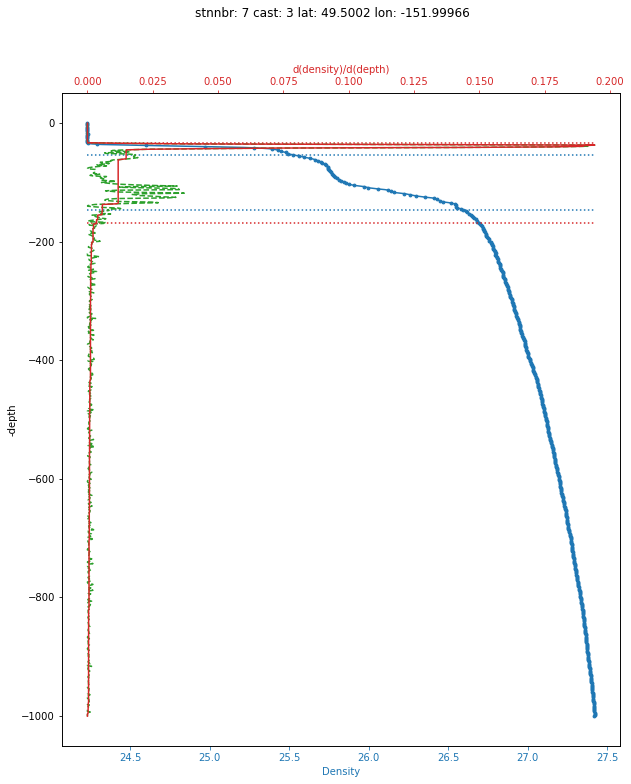

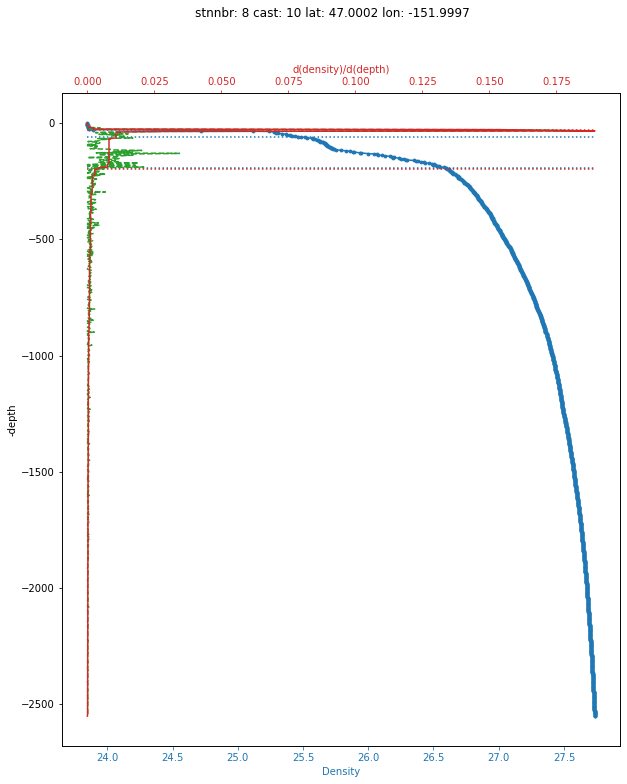

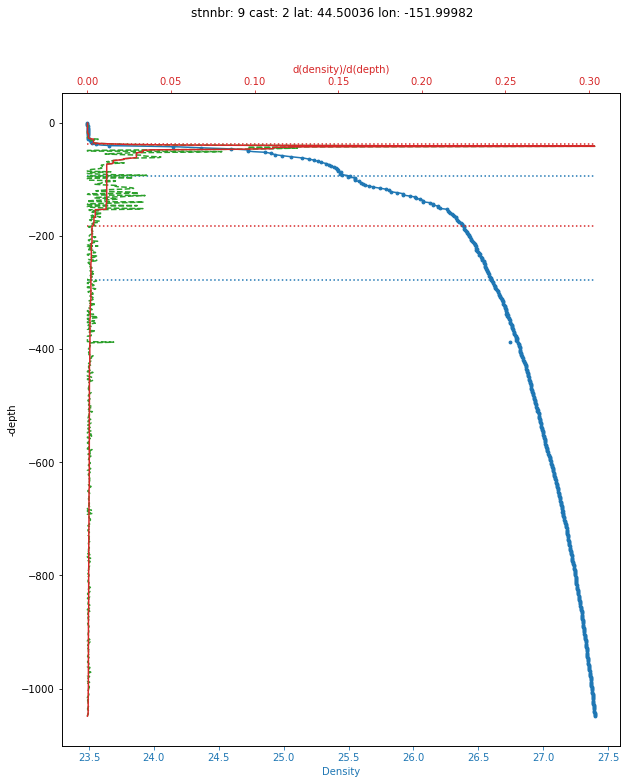

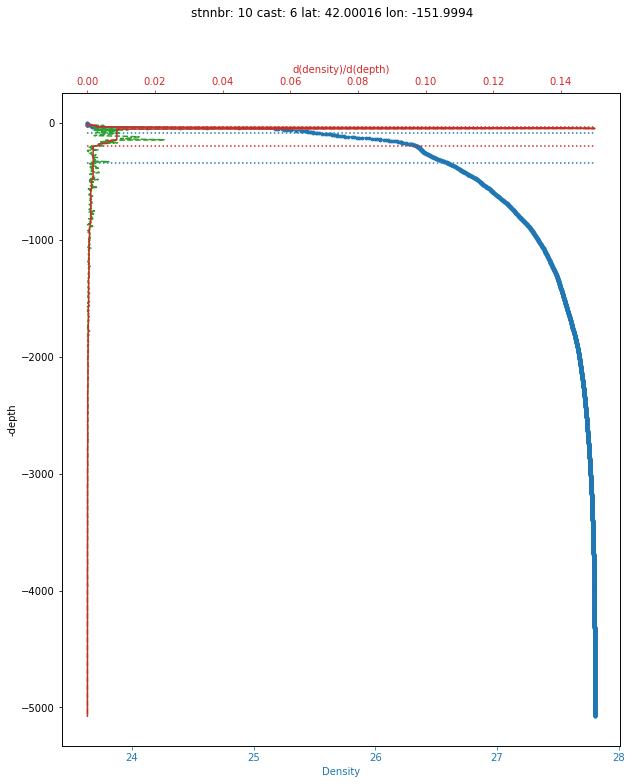

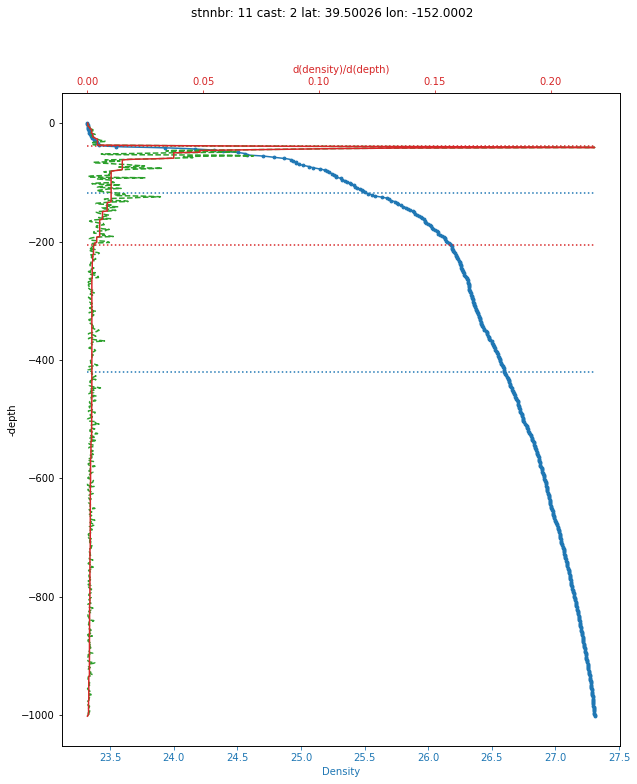

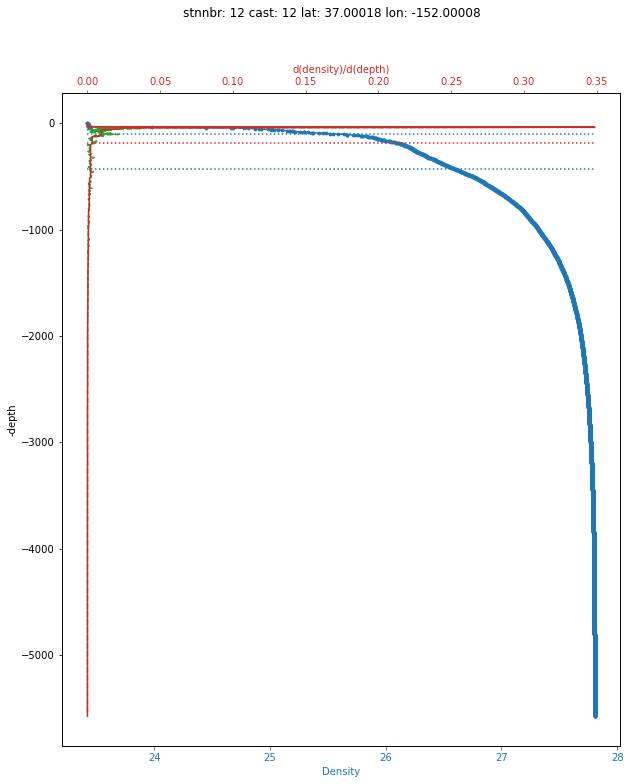

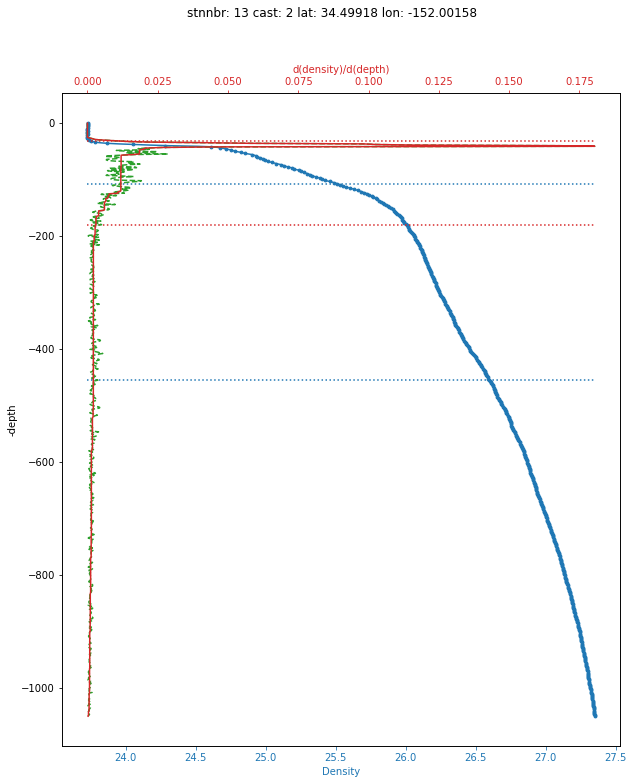

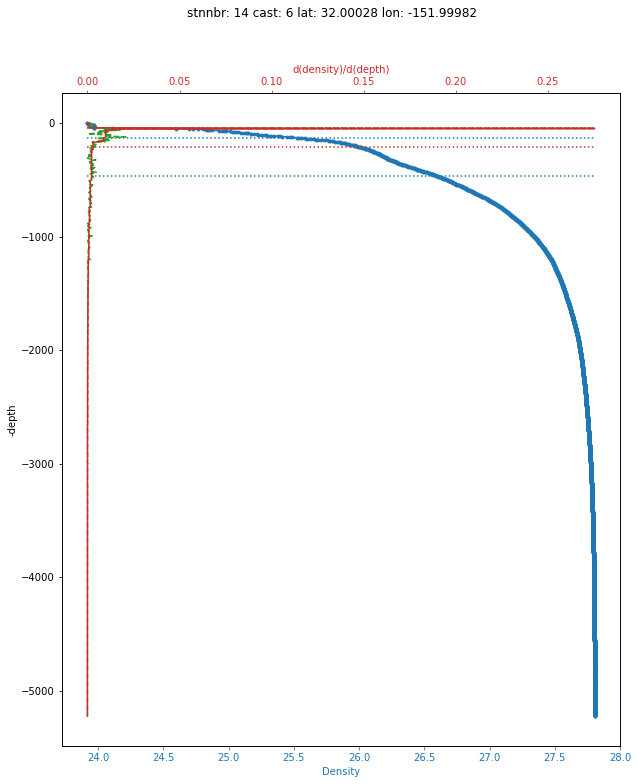

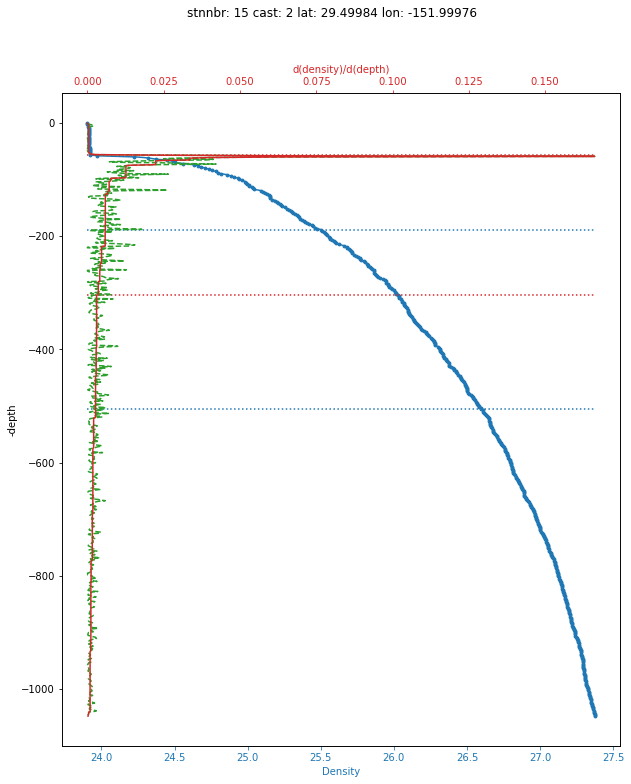

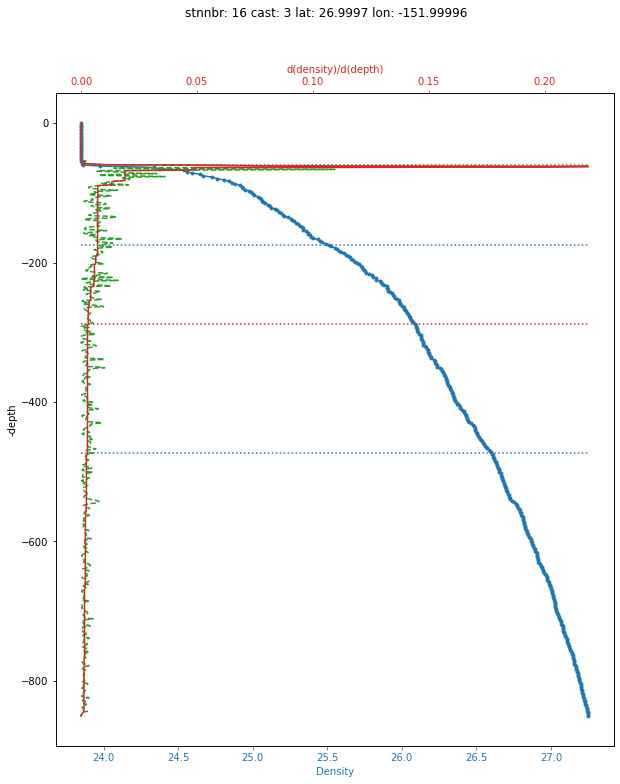

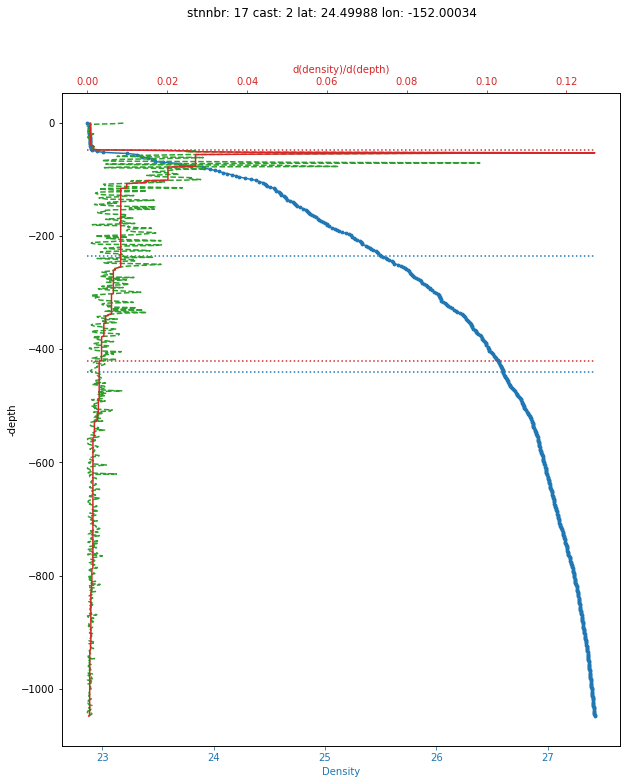

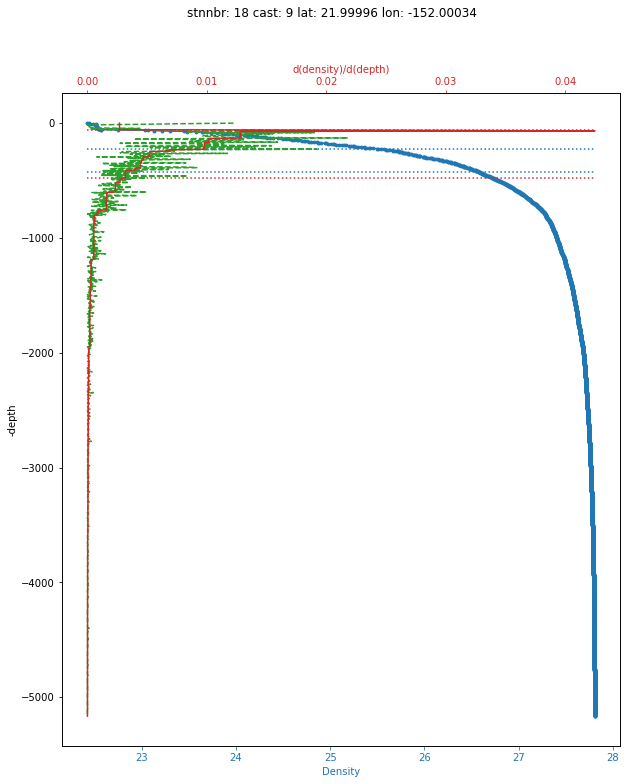

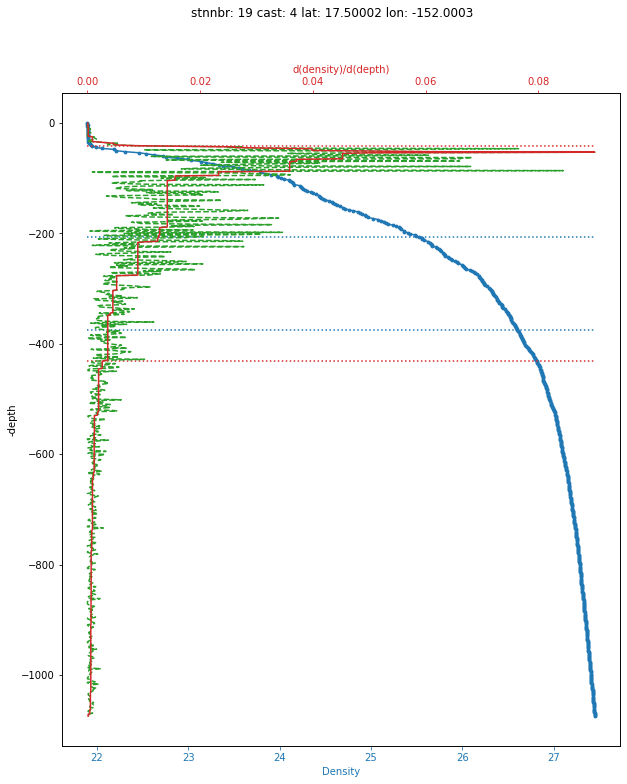

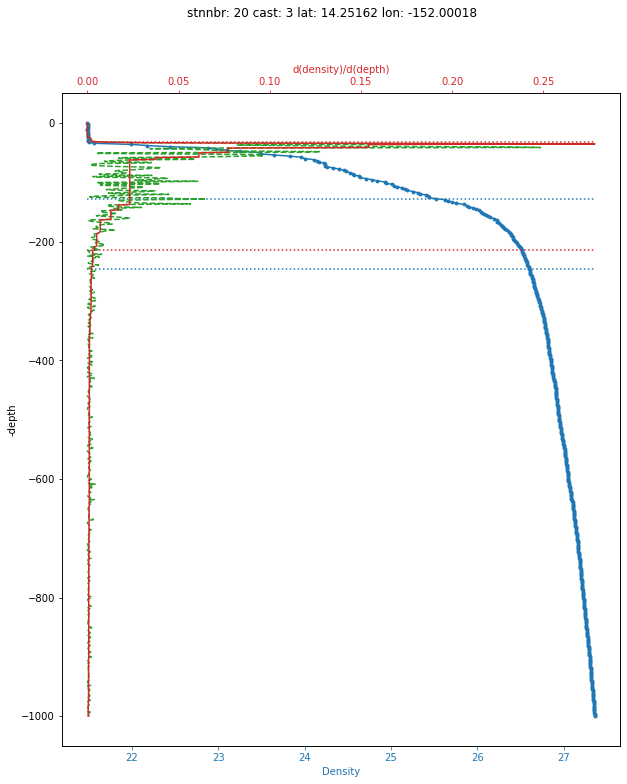

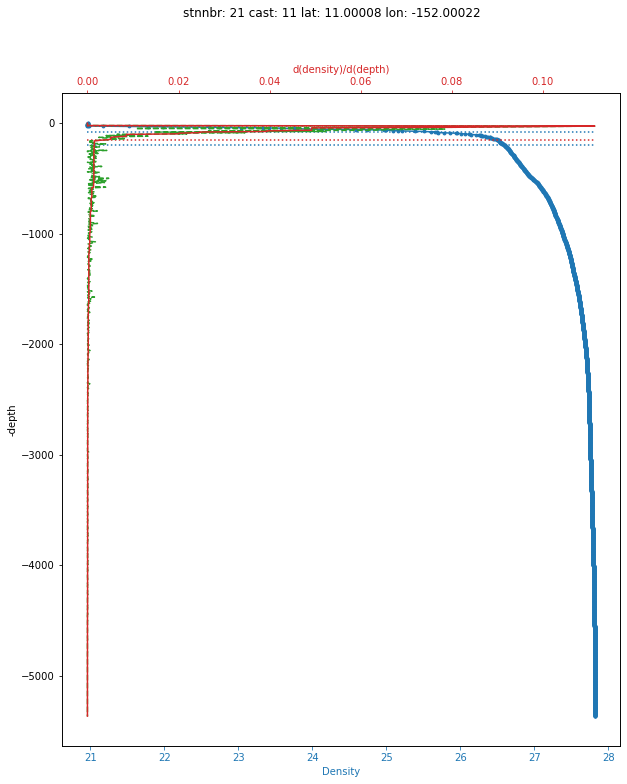

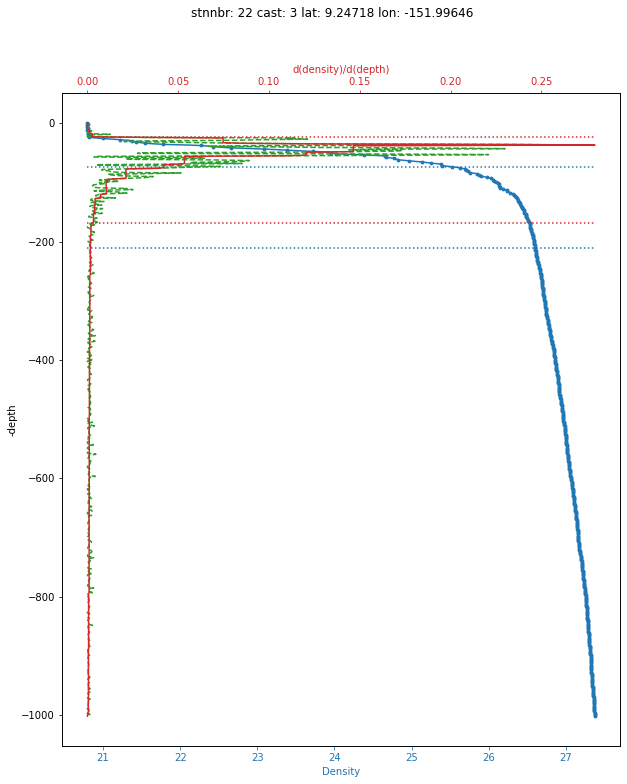

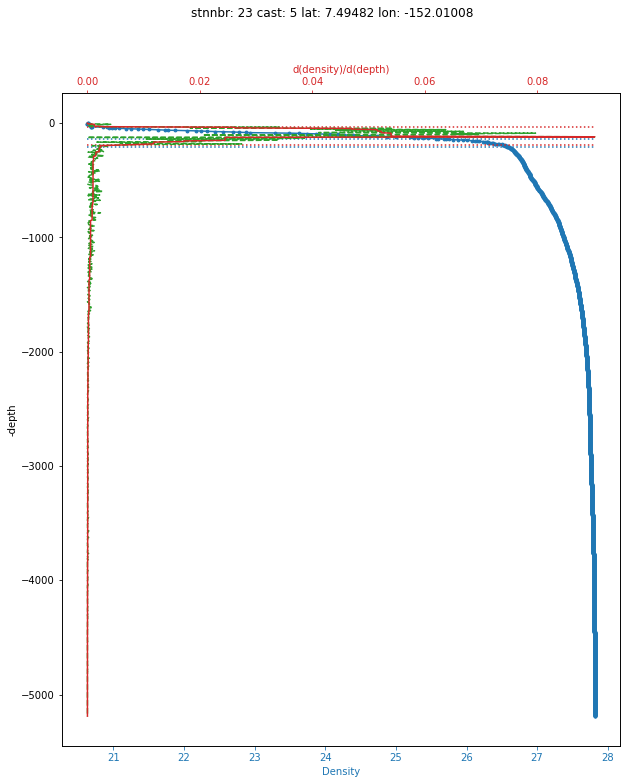

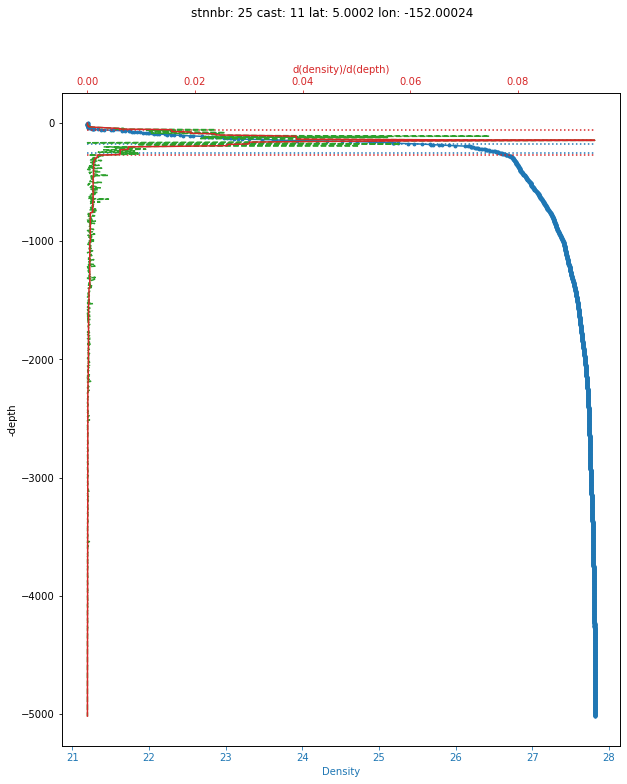

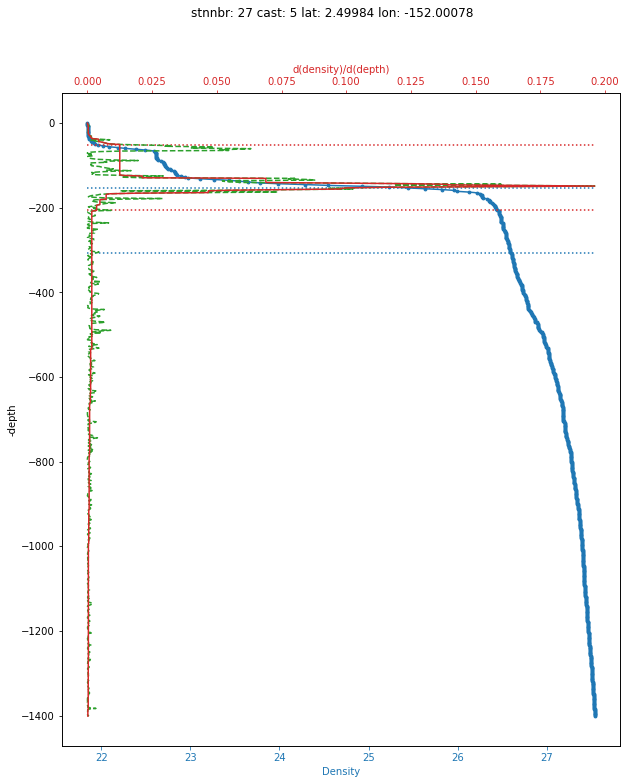

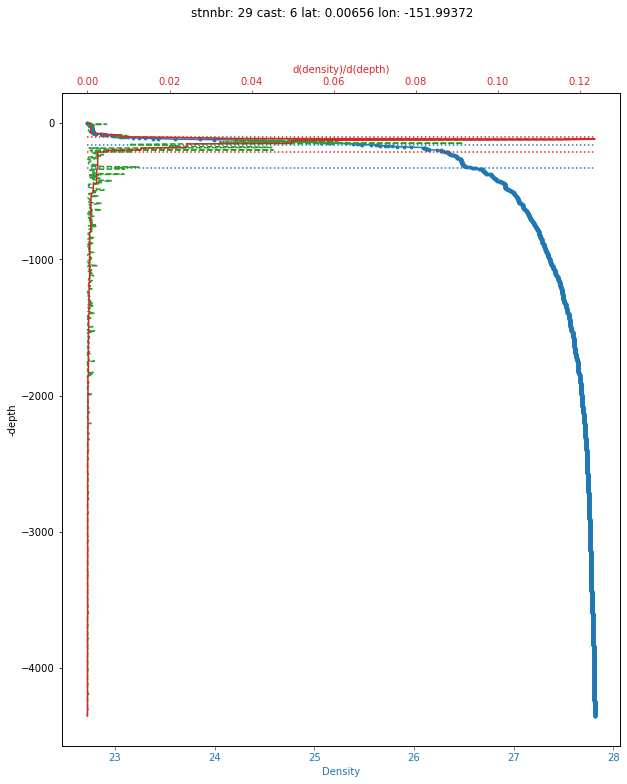

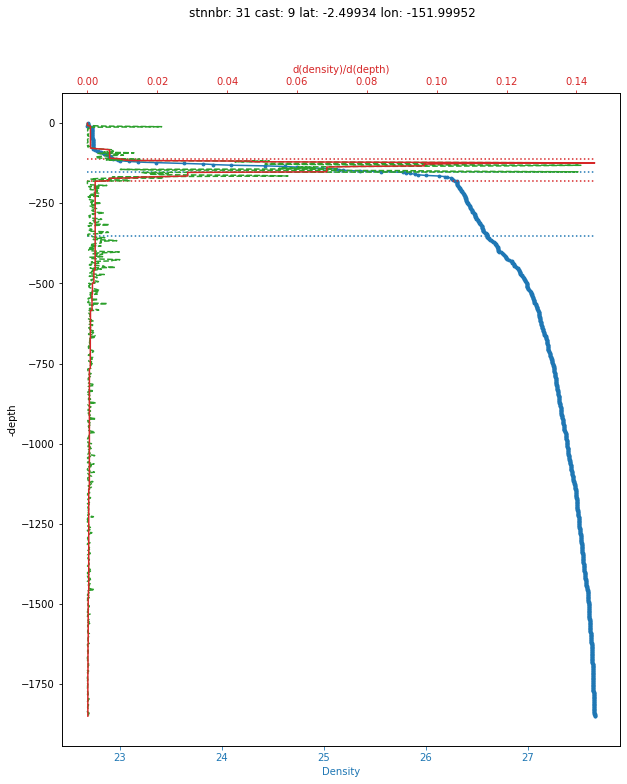

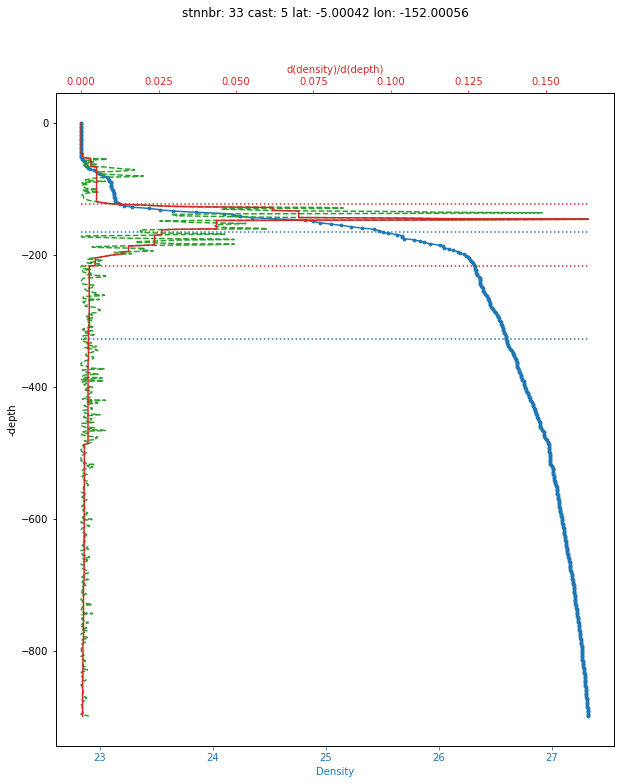

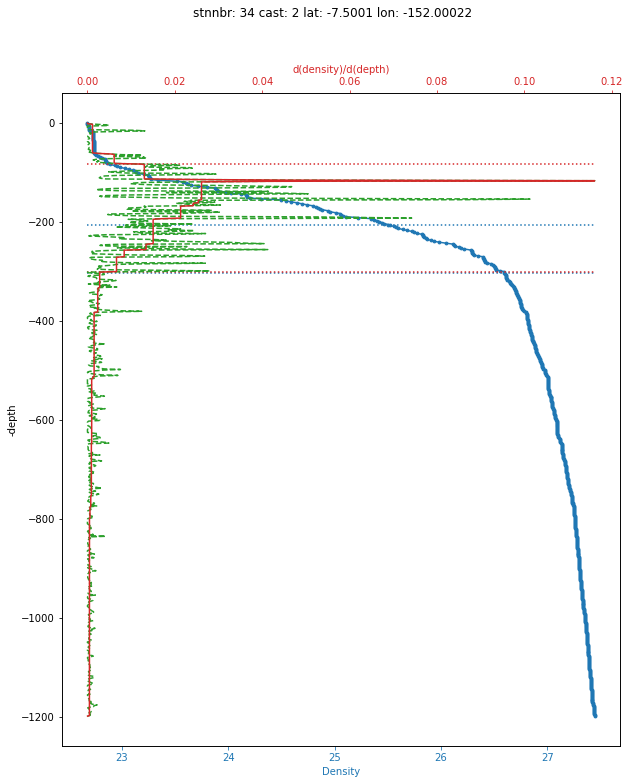

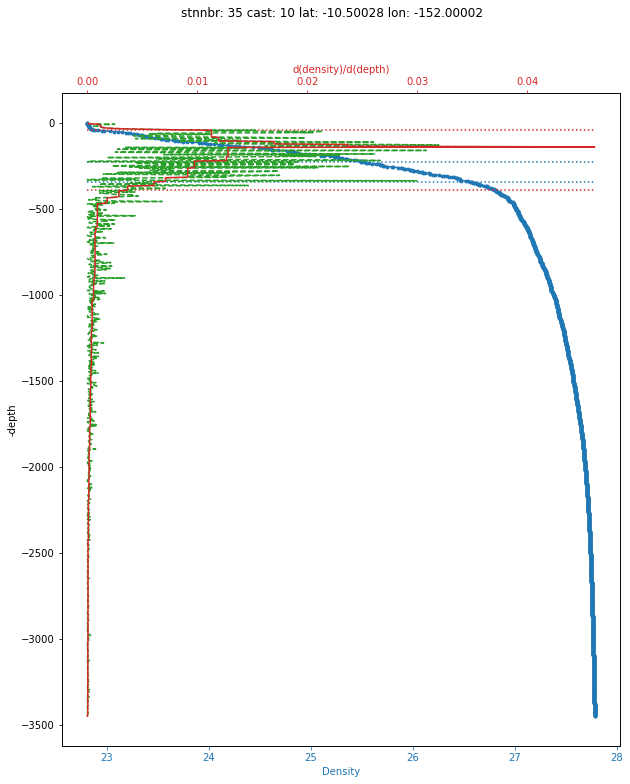

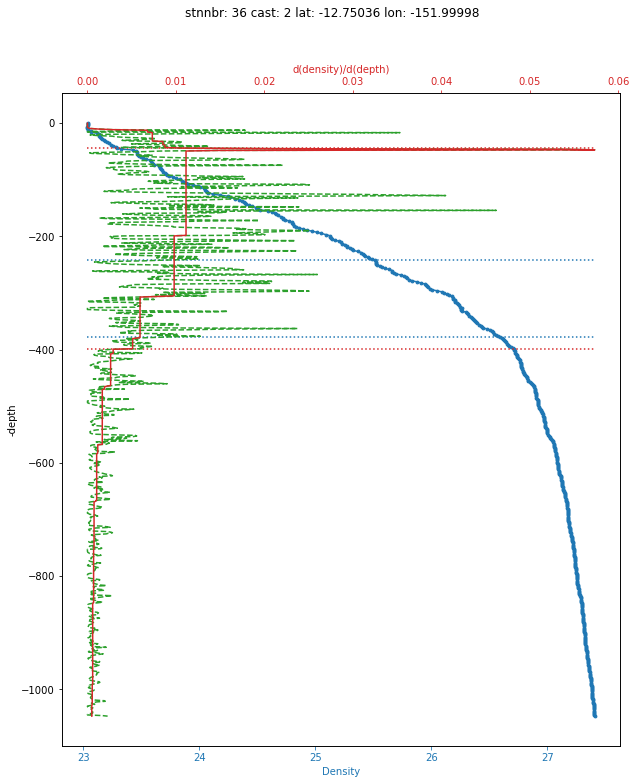

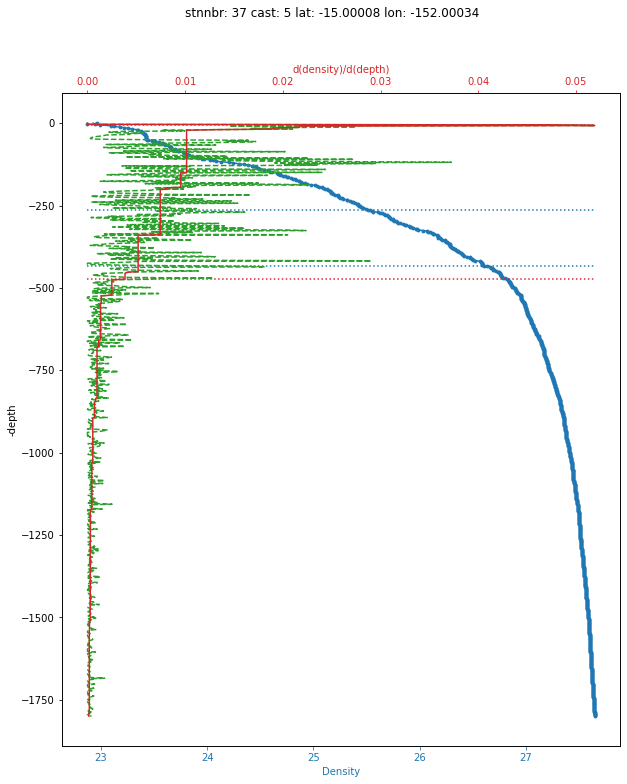

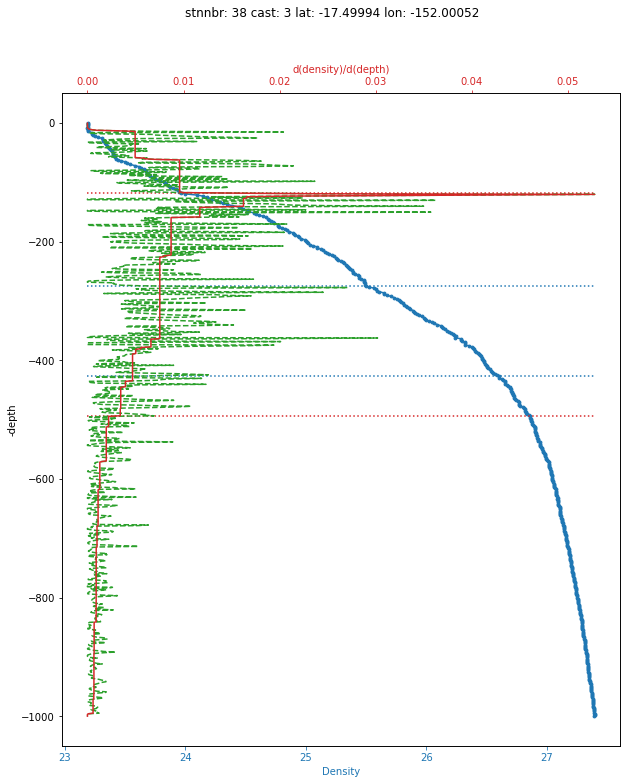

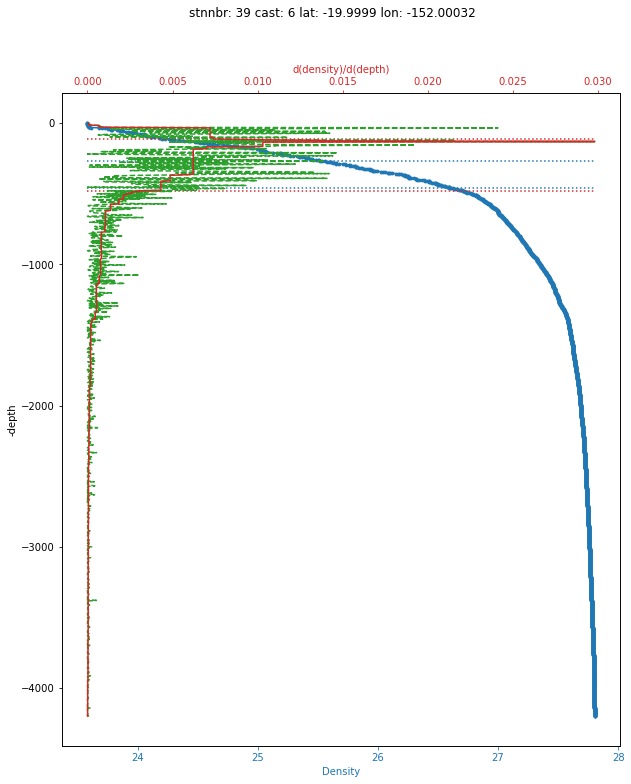

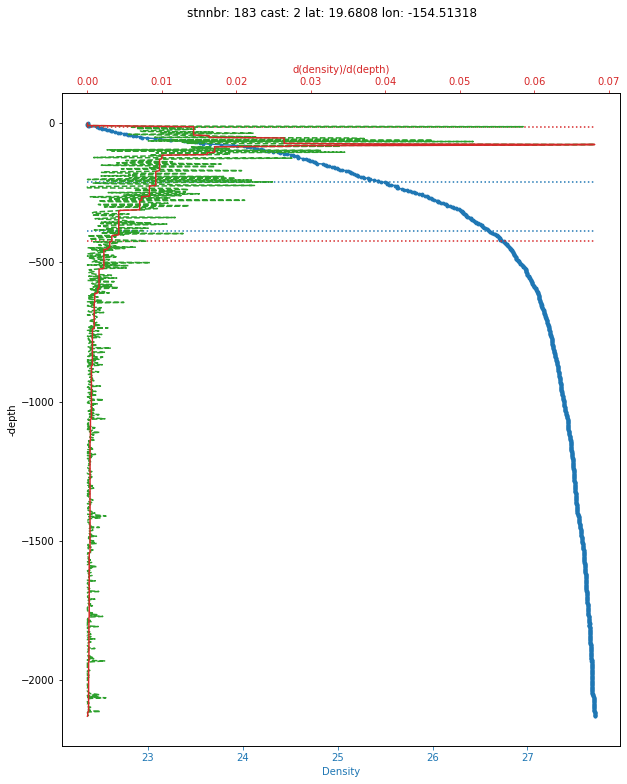

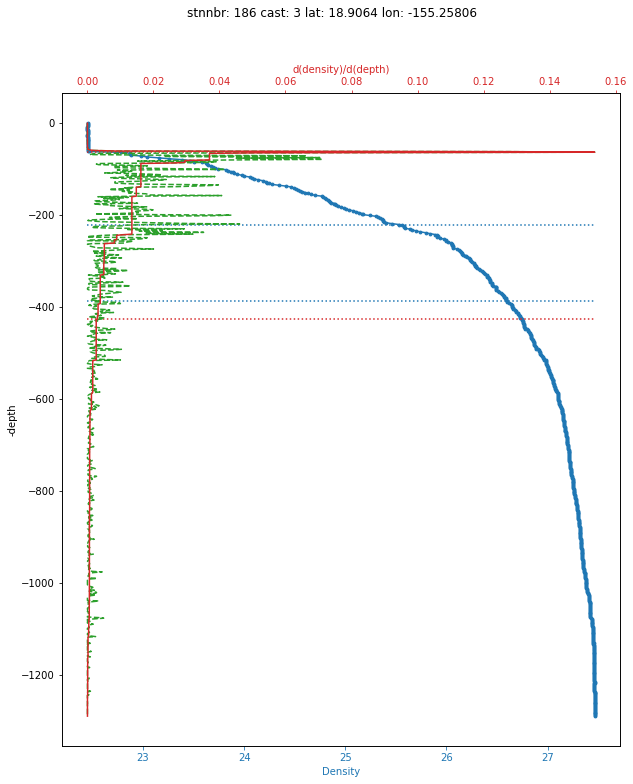

In [32]:
import scipy.interpolate
import scipy.signal
import sklearn.isotonic
import numpy as np
from matplotlib import pyplot as plt
from collections import OrderedDict

TC_UPPER_BOUND = 26.6
TC_LOWER_BOUND = 25.5

station_to_tcstartend = OrderedDict()

toplot_dataset = {"lat":[], "lon":[], "depth":[], "sig0":[]}

#let's plot the profiles per-station
for stn in sorted(stn_to_data.keys()):
    stn_data = stn_to_data[stn]
    #fit a spline to it
    density = np.array(stn_data.sig0)
    depth = np.array(stn_data.depth)

    argsort_depth = np.argsort(depth)
    sorted_depth = depth[argsort_depth]
    sorted_density = density[argsort_depth]
    
    #'correct' the density to enforce monotonic increase with depth
    sorted_monotonic_density = (sklearn.isotonic.IsotonicRegression()
       .fit_transform(X=sorted_depth, y=sorted_density))

    fig, ax1 = plt.subplots(figsize=(10,12))
    fig.suptitle("stnnbr: "+str(stn)
                 +" cast: "+str(stn_data.cast)
                 +" lat: "+str(stn_data.lat)
                 +" lon: "+str(stn_data.lon))
    ax1.set_ylabel("-depth")

    ax1.scatter(sorted_density, -sorted_depth, s=8, color='C0')

    ##Smooth the density with a savgol filter
    #sorted_smooth_density = scipy.signal.savgol_filter(sorted_density, 5, 2)
    #ax1.plot(sorted_smooth_density, -sorted_depth, color='C1')
    
    pchip_spl = scipy.interpolate.PchipInterpolator(
                 sorted_depth, sorted_monotonic_density)
    interp_depths = np.linspace(min(depth), max(depth), 1000)
    interp_density = pchip_spl(interp_depths)
    
    toplot_dataset["lat"].extend([stn_data.lat for x in interp_density])
    toplot_dataset["lon"].extend([stn_data.lon for x in interp_density])
    toplot_dataset["sig0"].extend(interp_density)
    toplot_dataset["depth"].extend(interp_depths)

    ax1.plot(interp_density, -interp_depths, color="C0")
    ax1.set_xlabel("Density")

    #Plot the flat density-based thresholds
    density_cutoff_tc_depths = (
        interp_depths[(interp_density <= TC_UPPER_BOUND)*
                      (interp_density >= TC_LOWER_BOUND)])
    density_cutoff_tc_start_depth = (np.min(density_cutoff_tc_depths) if
      len(density_cutoff_tc_depths) > 0 else np.nan)
    density_cutoff_tc_end_depth = (np.max(density_cutoff_tc_depths) if
      len(density_cutoff_tc_depths) > 0 else np.nan)
    ax1.plot([min(density), max(density)],
             [-density_cutoff_tc_start_depth, -density_cutoff_tc_start_depth],
             color="C0", linestyle=":")
    ax1.plot([min(density), max(density)],
             [-density_cutoff_tc_end_depth, -density_cutoff_tc_end_depth],
             color="C0", linestyle=":")
    #ax1.plot(akima_spl(interp_depths), -interp_depths)

    ax1.tick_params(axis='x', colors='C0')
    ax1.xaxis.label.set_color('C0')
    ax2 = ax1.twiny()
    ax2.tick_params(axis='x', colors='C3')
    ax2.xaxis.label.set_color('C3')

    first_derivatives = pchip_spl.derivative(1)(interp_depths)
    
    ax2.plot(first_derivatives, -interp_depths, color="C2", linestyle="--")
    
    ax2.set_xlabel("d(density)/d(depth)")
    
    #Procedure: find the maximum of the first derivative, then fit isotonic
    # regression to enforce monotonic increasing and monotic decreasing to
    # get a better estimate of the derivatives.

    max_first_d_depth = np.argmax(first_derivatives)+1
    if (max_first_d_depth > 1):
      increasing_first_d = sklearn.isotonic.IsotonicRegression().fit_transform(
            X=interp_depths[:max_first_d_depth],
            y=first_derivatives[:max_first_d_depth])
    else:
      increasing_first_d = [first_derivatives[0]]
    decreasing_first_d = -sklearn.isotonic.IsotonicRegression().fit_transform(
           X=interp_depths[max_first_d_depth:],
           y=-first_derivatives[max_first_d_depth:])

    corrected_first_d = np.array(list(increasing_first_d)
                                 +list(decreasing_first_d))
    ax2.plot(corrected_first_d, -interp_depths, color="C3")

    #threhsolds based on first_d
    THERM_SIGMA0_GRAD_START = min(0.25*np.max(corrected_first_d), 0.01)
    THERM_SIGMA0_GRAD_END = 0.003
    firstd_cutoff_tc_start_depth = np.min(
        interp_depths[(corrected_first_d >= THERM_SIGMA0_GRAD_START)])
    firstd_cutoff_tc_end_depth = (np.max(
        interp_depths[(corrected_first_d >= THERM_SIGMA0_GRAD_END)]) if
      sum((corrected_first_d >= THERM_SIGMA0_GRAD_END)) > 0 else np.nan)
    ax1.plot([min(density), max(density)],
             [-firstd_cutoff_tc_start_depth, -firstd_cutoff_tc_start_depth],
             color="C3", linestyle=":")
    ax1.plot([min(density), max(density)],
             [-firstd_cutoff_tc_end_depth, -firstd_cutoff_tc_end_depth],
             color="C3", linestyle=":")
    
    firstd_cutoff_tc_start_sig0,firstd_cutoff_tc_end_sig0 =\
        pchip_spl([firstd_cutoff_tc_start_depth, firstd_cutoff_tc_end_depth])
    station_to_tcstartend[stn] = {"sig0_cutoffs": (firstd_cutoff_tc_start_sig0,
                                                   firstd_cutoff_tc_end_sig0),
                                  "depth_cutoffs": (firstd_cutoff_tc_start_depth,
                                                    firstd_cutoff_tc_end_depth),
                                  "lat": stn_data.lat,
                                  "lon": stn_data.lon}
    plt.show()
    
#plt.show()

In [33]:
station_to_tcstartend

OrderedDict([(1,
              {'sig0_cutoffs': (24.119034048569933, 25.293068239301874),
               'depth_cutoffs': (26.097097116019086, 85.19934646700348),
               'lat': 56.0585,
               'lon': -156.9627}),
             (2,
              {'sig0_cutoffs': (24.629459626235786, 26.638738183551933),
               'depth_cutoffs': (30.22741174833166, 186.86036353514118),
               'lat': 55.59576,
               'lon': -156.34688}),
             (3,
              {'sig0_cutoffs': (24.25171406871839, 26.804831119015653),
               'depth_cutoffs': (27.213220596883733, 176.08554503865946),
               'lat': 55.08026,
               'lon': -155.72008}),
             (4,
              {'sig0_cutoffs': (24.547248253224435, 26.841137161700107),
               'depth_cutoffs': (30.266435146463408, 168.9875962344207),
               'lat': 54.66018,
               'lon': -155.17032}),
             (5,
              {'sig0_cutoffs': (24.52125612155552, 26.8565374

In [34]:
import json

with open("station_to_tc_cutoffs.json", "w") as f:
    f.write(json.dumps(station_to_tcstartend, sort_keys=True, indent=4))

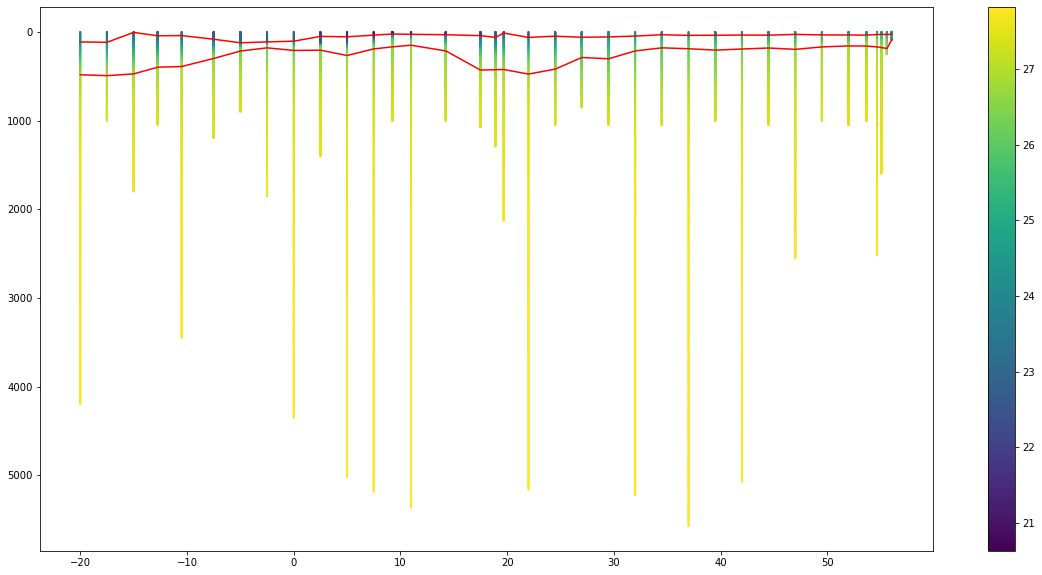

In [52]:
from matplotlib import pyplot as plt

tcstart_depths = np.array([x["depth_cutoffs"][0] for x in station_to_tcstartend.values()])
tcend_depths = np.array([x["depth_cutoffs"][1] for x in station_to_tcstartend.values()])
tc_lats = np.array([x["lat"] for x in station_to_tcstartend.values()])
#for plotting purposes, sort the bounds by latitude
argsort_lats = np.argsort(tc_lats)
tc_lats = tc_lats[argsort_lats]
tcstart_depths = tcstart_depths[argsort_lats]
tcend_depths = tcend_depths[argsort_lats]

plt.figure(figsize=(20,10))
plt.scatter(toplot_dataset["lat"], toplot_dataset["depth"],
            c=toplot_dataset["sig0"], s=1)
plt.colorbar()
plt.plot(tc_lats, tcstart_depths, color="red")
plt.plot(tc_lats, tcend_depths, color="red")
plt.ylim(plt.ylim()[1], plt.ylim()[0])
plt.show()